In [2]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,  roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [3]:
#import data
loan_data = pd.read_csv('./loan_data_2007_2014.csv')

c:\users\macma\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#drop columns with more than 80% null values
loan_data.dropna(thresh = loan_data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

In [5]:
#drop all redundant and forward-looking columns
loan_data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                            'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

In [6]:
#explore unique values in loan_status column
loan_data['loan_status'].value_counts(normalize = True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [7]:
#create new column based on loan_status column that will be the new target variable
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                        'Does not meet the credit policy. Status:Charged Off']),
                                0, 1)

In [8]:
#drop original loan_status column
loan_data.drop(columns = ['loan_status'], inplace = True)

In [9]:
#split the data into 80/20 while keeping the distribution of bad loans in the test set same as that in the pre-split dataset
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [10]:
#hard-copy the X datasets to avoid Pandas' SettingWithCopyWarning when playing around with this data
X_train, X_test = X_train.copy(), X_test.copy()

In [11]:
#function to clean up the emp_length column, assign 0 to NANs, and convert to numeric
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

In [12]:
'''
function to convert date columns to datetime format and
create a new column as a difference between today and the respective date

'''
def date_columns(df, column):
    #store current month
    today_date = pd.to_datetime('2020-11-03')

    #convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")

    #calculate difference in months and add to new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))

#make any resulting negative values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(
        lambda x: df['mths_since_' + column].max() if x < 0 else x
    )

    #drop original date column
    df.drop(columns = [column], inplace = True)

In [13]:
#function to remove 'months' string from the 'term' column and convert to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

In [14]:
#apply these functions to X_train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')
emp_length_converter(X_train, 'emp_length')
loan_term_converter(X_train, 'term')

In [15]:
#divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [16]:
#define empty dictionary to store chi-squared results
chi2_check = {}

In [17]:
#loop over each column in the training set to calculate the chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex  = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature', []).append(column)
    chi2_check.setdefault('p-value', []).append(round(p, 10))

In [18]:
#convert dicctionary to dataframe
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

In [19]:
#perform crude imputation of missing values since f_class_if does not accept missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)

In [20]:
#calculate F statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

c:\users\macma\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
c:\users\macma\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [21]:
#convert to DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
                                     'F-Score': F_statistic, 'p-values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

In [22]:
#save the top 20 nimerical features in a list
top_num_features = ANOVA_F_table.iloc[:20, 0].to_list()

<AxesSubplot:>

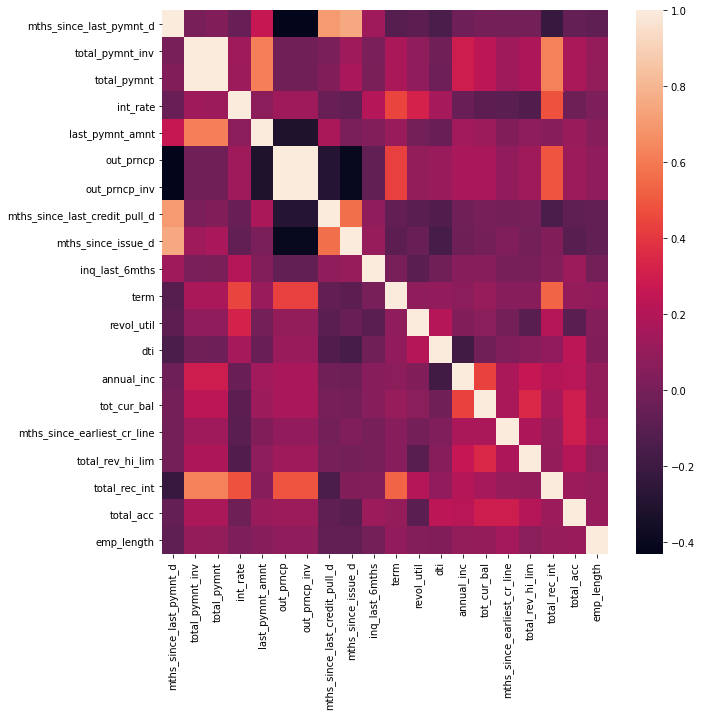

In [23]:
#calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat)

In [24]:
#save the names of the columns to be dropped in a list
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

In [25]:
#function to drop the columns
def column_to_drop(df, column_list):
    df.drop(columns = column_list, inplace = True)

In [26]:
#apply to X_train
column_to_drop(X_train, drop_columns_list)

In [27]:
#function to create dummy variables
def dummy_creation(df, column_list):
    df_dummies = []
    for col in column_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

In [28]:
#apply to four final category values
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])

In [29]:
#update test data with all functions defined
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
column_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])
#reindex the dummied test set variables to make sure all feature columns in the training set are also available in the test set
X_test = X_test.reindex(labels = X_train.columns, axis = 1, fill_value = 0)

In [30]:
#function to calculate the weight of evidence and information values
def woe_discrete(df, cat_variable_name, y_df):
    df = pd.concat([df[cat_variable_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [31]:
'''
function to calculate WoE & IV of continuous variables
This is same as the function we defined earlier for discrete variables
The only difference are the 2 commented lines of code in the function that results in the df
being sorted by continuous variable values
'''
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


In [32]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# function to plot WoE value
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

In [33]:
# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']

In [34]:
# custom transformer class to create new categorical dummy features
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['mths_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['mths_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['mths_since_earliest_cr_line'] > 125) & (X['mths_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['mths_since_earliest_cr_line'] > 167) & (X['mths_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['mths_since_earliest_cr_line'] > 249) & (X['mths_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['mths_since_earliest_cr_line'] > 331) & (X['mths_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['mths_since_earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['mths_since_issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['mths_since_issue_d'] > 79) & (X['mths_since_issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['mths_since_issue_d'] > 89) & (X['mths_since_issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['mths_since_issue_d'] > 100) & (X['mths_since_issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['mths_since_issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new

In [35]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

In [36]:
# define cross-validation criteria
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [37]:
# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

In [38]:
# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.8648
Gini: 0.7295


In [39]:
# fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0            5000         5000           4975.0   36 months     10.65   
1            2500         2500           2500.0   60 months     15.27   
2            2400         2400           2400.0   36 months     15.96   
3           10000        10000          10000.0   36 months     13.49   
4            3000         3000           3000.0   60 months     12.69   
...           ...          ...              ...         ...       ...   
466280      18400        18400          18400.0   60 months     14.47   
466281      22000        22000          22000.0   60 months     19.97   
466282      20700        20700          20700.0   60 months     1...
        acc_now_delinq tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
0                  0.0          NaN          NaN               NaN  
1                  0.0          NaN          NaN               NaN  
2           

In [40]:
# create a summary table
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients'
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)

In [41]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [42]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index

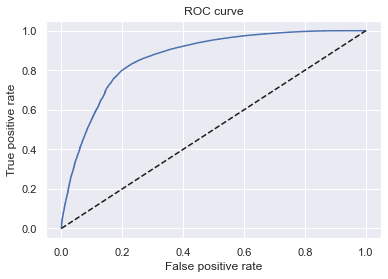

In [43]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], 
                                 y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [44]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
# print AUROC and Gini
print('AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (Gini))

AUROC: 0.8650
Gini: 0.7300


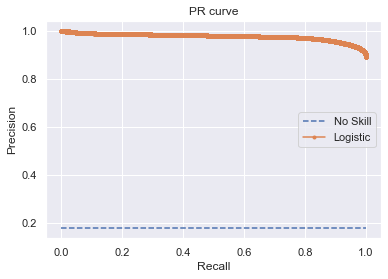

In [45]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# get the values required to plot a PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], 
                                                       y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [46]:
# create a new dataframe with one column with values from the 'reference_categories' list
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0

In [47]:
# Concatenates two dataframes
df_scorecard = pd.concat([summary_table, df_ref_categories])
# reset the index
df_scorecard.reset_index(inplace = True)

In [48]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]

In [49]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [50]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new column that has the imputed calculated Score based scaled from the coefficients
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (
    max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept
df_scorecard.loc[0, 'Score - Calculation'] = (
    (df_scorecard.loc[0,'Coefficients'] - min_sum_coef) /
    (max_sum_coef - min_sum_coef
    )) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

In [51]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
851.0


In [52]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
pd.options.display.max_rows = 102
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']

In [53]:
# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598

In [54]:
# Recheck min and max possible scores
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

294.0
845.0


In [55]:
# calculate credit scores for test set
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)

In [56]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 85)
(102,)


In [57]:
X_test.iloc[6991]

term                                             36
int_rate                                      15.31
grade                                             C
emp_length                                       10
home_ownership                                  OWN
annual_inc                                    35000
verification_status                    Not Verified
purpose                                 credit_card
dti                                           23.11
inq_last_6mths                                    1
revol_util                                     34.8
total_acc                                        40
out_prncp                                         0
total_pymnt                                 14268.5
total_rec_int                               2768.47
last_pymnt_amnt                              3459.1
tot_cur_bal                                   22601
total_rev_hi_lim                              31200
mths_since_earliest_cr_line                     342
mths_since_i

In [58]:
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,2.849188,Intercept,603.828038,604.0,0.171962,598.0
1,1,grade:A,0.957552,grade,24.770535,25.0,0.229465,25.0
2,2,grade:B,0.774335,grade,20.030968,20.0,-0.030968,20.0
3,3,grade:C,0.589911,grade,15.260158,15.0,-0.260158,15.0
4,4,grade:D,0.472503,grade,12.222981,12.0,-0.222981,12.0
5,5,grade:E,0.320126,grade,8.281222,8.0,-0.281222,8.0
6,6,grade:F,0.177443,grade,4.590192,5.0,0.409808,5.0
7,7,home_ownership:OWN,-0.047739,home_ownership,-1.234948,-1.0,0.234948,-1.0
8,8,home_ownership:OTHER_NONE_RENT,-0.107386,home_ownership,-2.777936,-3.0,-0.222064,-3.0
9,9,verification_status:Source Verified,-0.277835,verification_status,-7.187210,-7.0,0.187210,-7.0


In [59]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard,
# it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, 
				    pd.DataFrame(dict.fromkeys(ref_categories, [0]
							       * len(X_test_woe_transformed)), 
						 index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(102, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 102)
(102, 1)


In [60]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)

In [61]:
# Score cutoff for loan approvals
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.186152


In [62]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

In [63]:
# define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

In [64]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.18657, 0.18658)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
6591,0.186578,492.0,86492,6765,0.927459,0.072541
